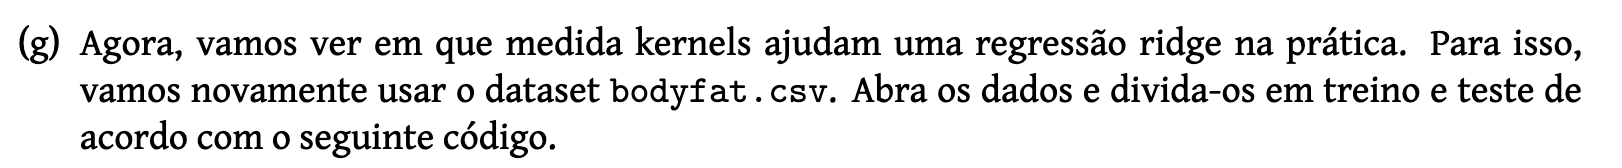

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from tqdm import tqdm


In [2]:
number_of_folds = 10
data = pd.read_csv("/Users/gabri/Classes/MachineLearning2026/data/bodyfat.csv")
X = data.drop(columns=["BodyFat","Density"])
y = data["BodyFat"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.2,
random_state=0)

### (i) Qual é o erro médio quadrático de uma regressão linear nos dados de teste?

In [3]:
from sklearn.metrics import mean_squared_error

def MSE(y_hat, y_true):
    n = len(y_hat)
    if len(y_hat) == 0 or len(y_true) == 0:
        raise Exception('Vetores inválidos')
    elif len(y_hat) != len(y_true):
        raise Exception('Os vetores devem ter o mesmo tamanho')
    return np.sum((y_true - y_hat)**2)/n

In [4]:
lr = LinearRegression()
model = lr.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = MSE(y_pred, y_test)
print('MSE from function = ',mse)
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
print('MSE from sklearn = ',mse)

MSE from function =  15.910489104854422
MSE from sklearn =  15.910489104854422


In [5]:
X_train

,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
162,33,184.25,68.75,40.7,98.9,92.1,103.5,64.0,37.3,23.5,33.5,30.6,19.7
159,31,177.25,71.50,36.2,101.1,92.4,99.3,59.4,39.0,24.6,30.1,28.2,18.2
76,57,162.50,69.50,38.7,91.6,78.8,94.3,56.7,39.7,24.2,30.2,29.2,18.1
59,61,179.75,65.75,38.4,104.8,98.3,99.6,60.6,37.7,22.9,34.5,29.6,18.5
176,37,151.00,67.00,35.3,92.6,83.2,96.4,60.0,38.1,22.0,31.5,26.6,16.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,55,154.75,71.50,36.9,95.4,86.6,91.8,54.3,35.4,21.5,32.8,27.4,18.7
192,42,193.50,70.50,40.7,104.9,94.1,102.7,60.6,38.6,24.7,34.0,30.1,18.7
117,51,179.00,72.00,41.0,99.2,90.0,96.4,56.8,38.8,23.3,33.4,29.8,19.5
47,39,148.50,71.25,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9


In [6]:
y_train

162    13.0
159    22.5
76      8.8
59     24.6
176    13.1
       ... 
67     13.8
192    15.9
117    13.9
47      5.6
172    20.5
Name: BodyFat, Length: 201, dtype: float64

In [ ]:
from sklearn.preprocessing import StandardScaler

alphas = 10**np.linspace(3,-2,100)
ridge_cv_mse = {}

for alpha in tqdm(alphas):
    cv_MSE = []
    folds = KFold(n_splits = number_of_folds, shuffle = True,random_state = 2023).split(X_train, y_train)
    for train_idx, val_idx in folds:
        ridge_pipeline = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
        ridge_pipeline.fit(X_train.iloc[train_idx], y_train.iloc[train_idx]) # treine seu modelo nos folds de treino
        y_hat = ridge_pipeline.predict(X_train.iloc[val_idx]) # faça suas previsões no fold de validação
        cv_MSE.append(mean_squared_error(y_pred=y_hat, y_true=y_train.iloc[val_idx])) # salve o MSE encontrado no fold de validação


    ridge_cv_mse[alpha] = np.mean(cv_MSE)

optimal_alpha = min(ridge_cv_mse, key=ridge_cv_mse.get)

ridge_pipeline = make_pipeline(StandardScaler(), Ridge(alpha=optimal_alpha))
ridge_pipeline.fit(X_train, y_train) 
y_hat_ridge = ridge_pipeline.predict(X_test) # faça as previsões em todo o conjunto de teste
ridge_test_mse = mean_squared_error(y_pred=y_hat_ridge, y_true=y_test) # salve o MSE encontrado no conjunto de teste
print(f'MSE test set = {ridge_test_mse}')

100%|██████████| 100/100 [00:02<00:00, 40.86it/s]

MSE test set = 15.872514115940737


In [16]:
kernels = ["linear", "polynomial", "rbf", "laplacian"]
gammas = [10**-3]
alphas = 10**np.linspace(3,-2,100)
hyperparams = [(kernel, gamma, alpha) for kernel in kernels for gamma in gammas for alpha in alphas]

for hyperparams_set in tqdm(hyperparams):

    kernel = hyperparams_set[0]
    gamma = hyperparams_set[1]
    alpha = hyperparams_set[2]

    cv_MSE = []
    folds = KFold(n_splits = number_of_folds, shuffle = True,random_state = 2023).split(X_train, y_train)
    for train_idx, val_idx in folds:
        ridge_pipeline = make_pipeline(StandardScaler(), KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma))
        ridge_pipeline.fit(X_train.iloc[train_idx], y_train.iloc[train_idx]) # treine seu modelo nos folds de treino
        y_hat = ridge_pipeline.predict(X_train.iloc[val_idx]) # faça suas previsões no fold de validação
        cv_MSE.append(mean_squared_error(y_pred=y_hat, y_true=y_train.iloc[val_idx])) # salve o MSE encontrado no fold de validação


    ridge_cv_mse[hyperparams_set] = np.mean(cv_MSE)

optimal_hyperparams = min(ridge_cv_mse, key=ridge_cv_mse.get)
print('Optimal hyperparameters: ', optimal_hyperparams)
ridge_pipeline = make_pipeline(StandardScaler(), KernelRidge(alpha=optimal_hyperparams[2], kernel=optimal_hyperparams[0], gamma = optimal_hyperparams[2]))
ridge_pipeline.fit(X_train, y_train) 
y_hat_ridge = ridge_pipeline.predict(X_test) # faça as previsões em todo o conjunto de teste
ridge_test_mse = mean_squared_error(y_pred=y_hat_ridge, y_true=y_test) # salve o MSE encontrado no conjunto de teste
print(f'MSE test set = {ridge_test_mse}')

100%|██████████| 400/400 [00:11<00:00, 34.00it/s]

Optimal hyperparameters:  ('rbf', 0.001, np.float64(0.01))
MSE test set = 15.994937064274248
